Web Traffic Time Series Forecasting - EDA
=========================================


* [1 Data Inspection](#data-inspection)
  * [1.1 Libraries and definitions](#libraries-and-definitions)
  * [1.2 Load data](#load-data)
  * [1.3 Missing values](#missing-values)
* [2 Data Preparation](#data-preparation)
* [3 Dataset overview](#dataset-overview)
  * [3.1 Overview of metadata](#overview-metadata)
  * [3.2 Statistics of time series](#statistics-time-series)
* [4 Correlation of views ~ day](#correlation-views)
  * [4.1 Distribution of $\rho$](#distrib-rho)
  * [4.2 Top correlated time series](#top-correlated-time-series)
* [5 Series of top mean / stdev views](#series-top-mean-stdev)
  * [5.2 Series of top standard deviation](#series-top-stdev)
  * [5.3 Series of top normalized stdev](#series-top-normlized-stdev)
* [6 Properties for Forecasting](#properties-forecasting)
  * [6.1 Seasonality](#seasonality)
  * [6.2 Spectrum with FFT](#spectrum-with-fft)
  * [6.3 Autocorrelation and partial autocorrelation](#autocorrelation-partial-autocorrelation)
  * [6.4 Augmented Dickey-Fuller tests](#adf-tests)

# 1 Data inspection <a class="anchor" id="data-inspection"></a>

## 1.1 Libraries and definitions <a class="anchor" id="libraries-and-definitions"></a>

In [1]:
# Python libs
import warnings
import joblib
from pathlib import Path
from itertools import product
from math import ceil
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.nonparametric.smoothers_lowess import lowess

# Module settings
mpl.rc("figure", dpi=96)
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #Show Chinese label
sns.set()
#pd.set_option('display.max_columns', None)  # show all columns

In [6]:
DATA_INPUT_DIR = "data_input/"
DATA_PROCESSED_DIR = "data_processed/"

TRAIN_CSV = DATA_INPUT_DIR + "train_1.csv"
TRAIN2_CSV = DATA_INPUT_DIR + "train_2.csv"
KEY_1_CSV = DATA_INPUT_DIR + "key_1.csv"
KEY_2_CSV = DATA_INPUT_DIR + "key_2.csv"
SAMPLE_SUBMISSION_1_CSV = DATA_INPUT_DIR + "sample_submission_1.csv"
SAMPLE_SUBMISSION_2_CSV = DATA_INPUT_DIR + "sample_submission_2.csv"

TRAIN_FLAT = DATA_PROCESSED_DIR + "train_flat.pkl"

In [3]:
def set_xlabel_rotation(ax, deg=90):
    for label in ax.get_xticklabels():
        l = label.set_rotation(deg)

## 1.2 Load data <a class="anchor" id="load-data"></a>

In [4]:
train = pd.read_csv(TRAIN_CSV)
train.shape
train.info()
train

(145063, 551)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- The train_1 data contains 145063 page/access/agent combinations and spans over 550 days from 2015-07-01 to 2016-12-31.
- The dataset size is about 610 MB in memory.

## 1.3 Missing values <a class="anchor" id="missing-values"></a>

In [5]:
missing_ratio = train[train.columns[1:]].isnull().sum().sum() / train[train.columns[1:]].size
print(f"{missing_ratio*100:.2f}% missing values.")

7.76% missing values.


In [6]:
# For exploratory data analysis, NaN values are not filled, as 0-filling will change summary statistics and distributions. It will be done at the training stage.
#train.fillna(value=0, inplace=True)

There are about 7.8% missing values in the train_1 dataset, which need to be imputed later at the modeling stage.

# 2 Data Preparation <a class="anchor" id="data-preparation"></a>

- We are going to split `Page` column to multiple featuers and store them in a metadata dataframe.
- Page views time series will be stored separately in a time series dataframe, with dates represented in integer counting.

In [6]:
meta = train['Page'].str.rsplit('_', n=3, expand=True)
meta.columns = ['name', 'project', 'access', 'agent']
meta.head()

,name,project,access,agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider


In [7]:
for col in ['project', 'access', 'agent']:
    meta[col].unique()


array(['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org',
       'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org',
       'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org'],
      dtype=object)

array(['all-access', 'desktop', 'mobile-web'], dtype=object)

array(['spider', 'all-agents'], dtype=object)

- 3 project websites: wikipedia, wikimedia, and mediawiki. Most of visits are on wikipedia.org in 7 languages.
- 3 access types: all-access, desktop and mobile-web.
- 2 kinds of agents: spider or all-agents.

In [8]:
lang_project = meta['project'].str.split('.', n=1, expand=True)
lang_project.columns = ['lang', 'site']
meta = pd.concat([meta[['name', 'access', 'agent']], lang_project], axis=1)

meta['lang'] = meta['lang'].str.replace('www', 'mw')
meta['lang'] = meta['lang'].str.replace('commons', 'wm')

meta['lang'].unique()
meta['site'].unique()

array(['zh', 'fr', 'en', 'wm', 'ru', 'mw', 'de', 'ja', 'es'], dtype=object)

array(['wikipedia.org', 'wikimedia.org', 'mediawiki.org'], dtype=object)

In [9]:
meta.query('name.str.contains("The_Rolling_Stones")')

,name,access,agent,lang,site
6029,The_Rolling_Stones,desktop,all-agents,fr,wikipedia.org
8696,Blue_&_Lonesome_(The_Rolling_Stones_album),desktop,all-agents,en,wikipedia.org
12725,The_Rolling_Stones,desktop,all-agents,en,wikipedia.org
25420,The_Rolling_Stones,all-access,all-agents,fr,wikipedia.org
36536,The_Rolling_Stones,all-access,spider,en,wikipedia.org
41456,The_Rolling_Stones,all-access,all-agents,en,wikipedia.org
49653,The_Rolling_Stones,all-access,spider,de,wikipedia.org
54230,The_Rolling_Stones,mobile-web,all-agents,fr,wikipedia.org
68152,The_Rolling_Stones,desktop,all-agents,de,wikipedia.org
71361,The_Rolling_Stones,desktop,all-agents,es,wikipedia.org


In [10]:
ts = train[train.columns[5:]]
ts.columns = range(len(ts.columns))
ts

,0,1,2,3,4,5,6,7,8,9,...,536,537,538,539,540,541,542,543,544,545
0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0
145059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3 Dataset overview <a class="anchor" id="dataset-overview"></a>

This section will look into the overall characteristics of the dataset: firstly on the distribution of meta data classes, and then the statistics of time series over the time horizon.

## 3.1 Overview of metadata <a class="anchor" id="overview-metadata"></a>

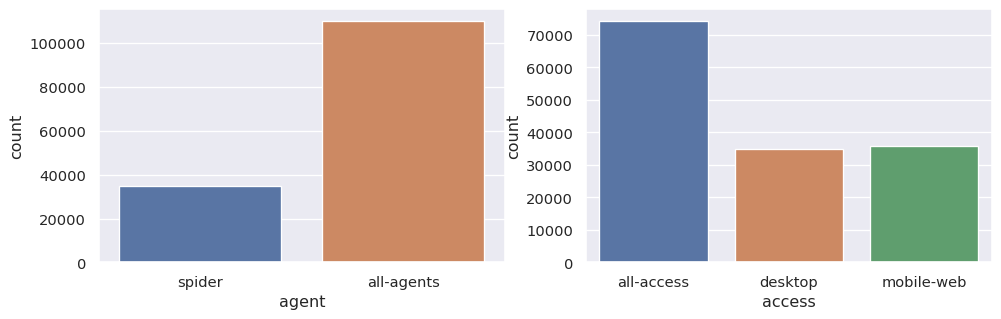

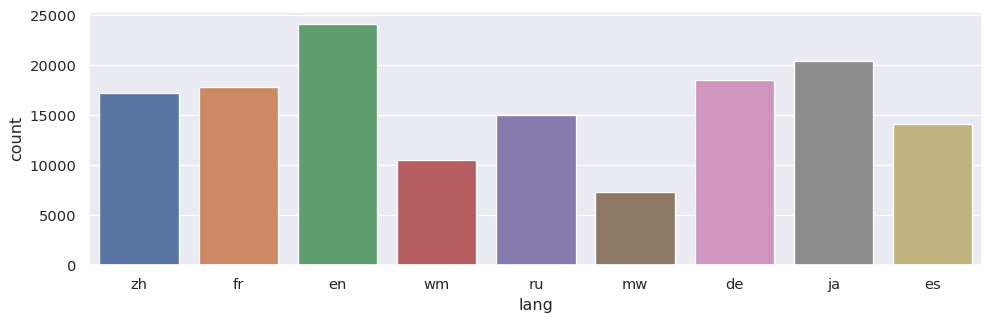

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
_ = sns.countplot(data=meta, x='agent', ax=ax.flatten()[0])
_ = sns.countplot(data=meta, x='access', ax=ax.flatten()[1])
fig, ax = plt.subplots(figsize=(12, 3.5))
_ = sns.countplot(data=meta, x='lang')

Counts of pages:
- `all-agents` and `all-access` are the main types regarding agent and access fields.
- Mobile site entries are slightly more than desktop sites.
- On wikipedia.org, English, Japanese, German are the top 3 languages.
- Wikimedia and mediawiki have much less pages than any language of wikipedia.org.

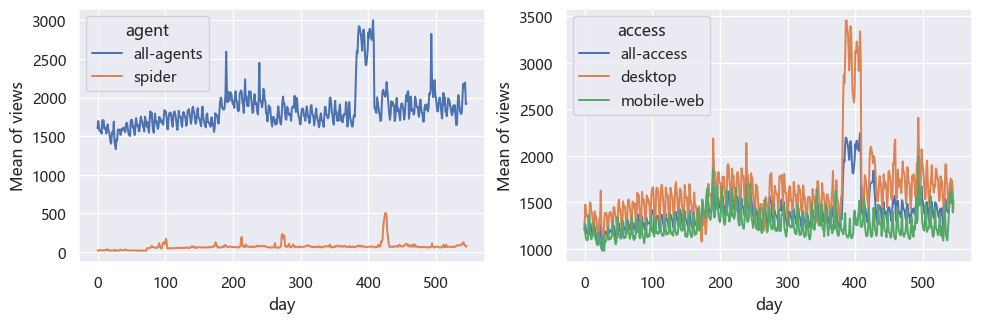

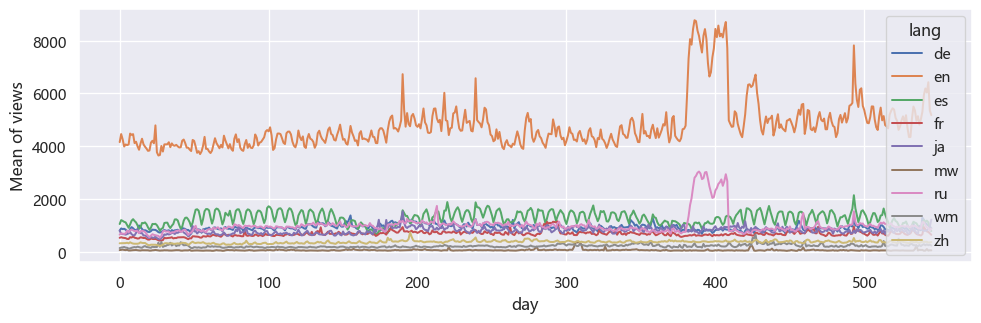

In [103]:
meta_ts = pd.concat([meta, ts], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
ax = meta_ts.groupby('agent').mean().T.plot(ax=axes.flatten()[0])
_ = ax.set(xlabel='day', ylabel='Mean of views')
ax = meta_ts.groupby('access').mean().T.plot(ax=axes.flatten()[1])
_ = ax.set(xlabel='day', ylabel='Mean of views')
ax = meta_ts.groupby('lang').mean().T.plot(figsize=(12, 3.5))
_ = ax.set(xlabel='day', ylabel='Mean of views')

- Regarding average views per day, all-agents views are much higher than spider, while 3 access methods are close, except desktop access is slightly higher.
- Over time horizon, English page views are much higher than other languages, and Spanish follows as the 2nd one.
- For some reason, wikipedia English and Russian views jumped up in summer 2016.

## 3.2 Statistics of time series <a class="anchor" id="statistics-time-series"></a>

In [46]:
ts_stats = pd.DataFrame({
    'mean': ts.mean(axis=1),
    'std': ts.std(axis=1),
    'max': ts.max(axis=1),
    'min': ts.min(axis=1),
})

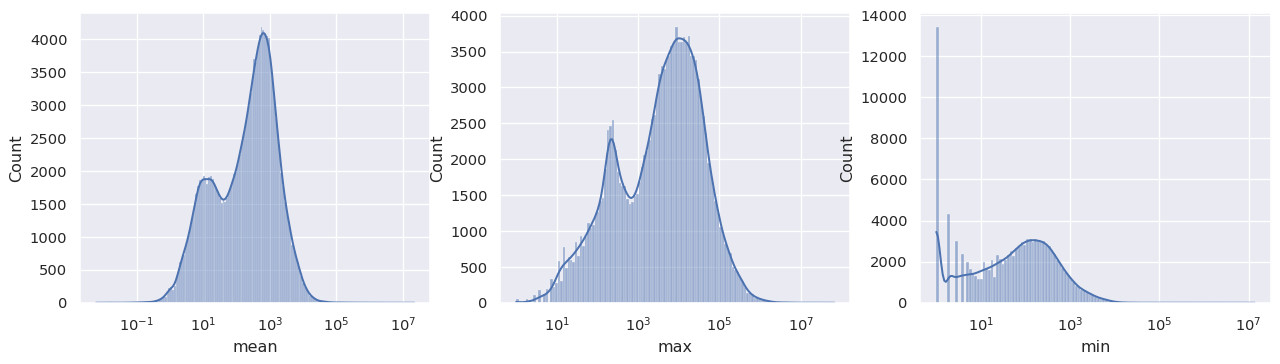

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4));
p = sns.histplot(data=ts_stats[ts_stats['mean']>0]['mean'], kde=True, ax=ax.flatten()[0], log_scale=True)
p = sns.histplot(data=ts_stats[ts_stats['max']>0]['max'], kde=True, ax=ax.flatten()[1], log_scale=True)
p = sns.histplot(data=ts_stats[ts_stats['min']>0]['min'], kde=True, ax=ax.flatten()[2], log_scale=True)

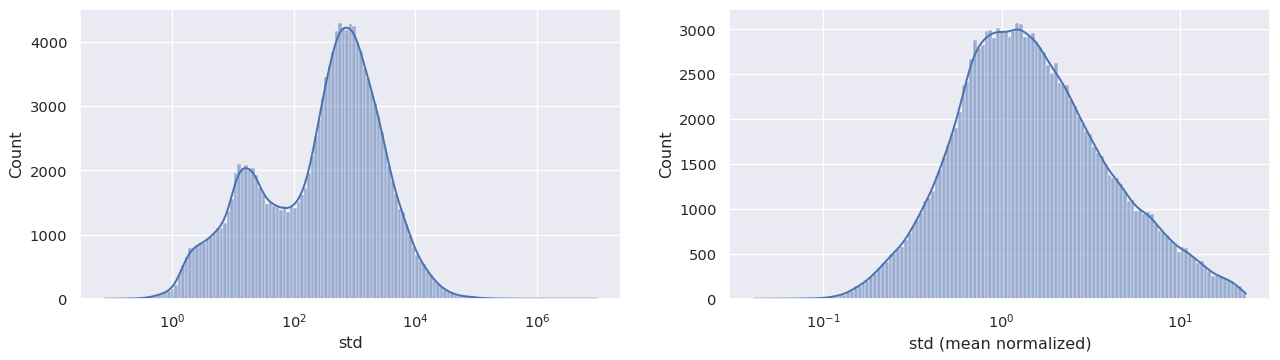

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
p = sns.histplot(data=ts_stats[ts_stats['std']>0]['std'], kde=True, ax=ax.flatten()[0], log_scale=True)
ts_std_norm = ts_stats[ts_stats['std']>0]['std']/ts_stats[ts_stats['std']>0]['mean']
ts_std_norm.name = 'std (mean normalized)'
p = sns.histplot(data=ts_std_norm, kde=True, ax=ax.flatten()[1], log_scale=True)


Distributions of average views:
- Bimodal distributed for mean and max views across wide range from 1 to 1e+5 views.
- The normalized standard deviation has a right-skewed distribution.

In [88]:
ts_stats_lang_all = {'mean': {}, 'max': {}, 'std': {}}

for lang in meta['lang'].unique():
        ts_stats_lang = ts_stats.loc[meta[meta['lang'] == lang].index]
        ts_stats_lang['std'] = ts_stats_lang['std'] / ts_stats_lang['mean']
        for stats_name in ts_stats_lang_all:
            ts_stats_lang_all[stats_name][lang] = ts_stats_lang[ts_stats_lang[stats_name] > 0][stats_name]


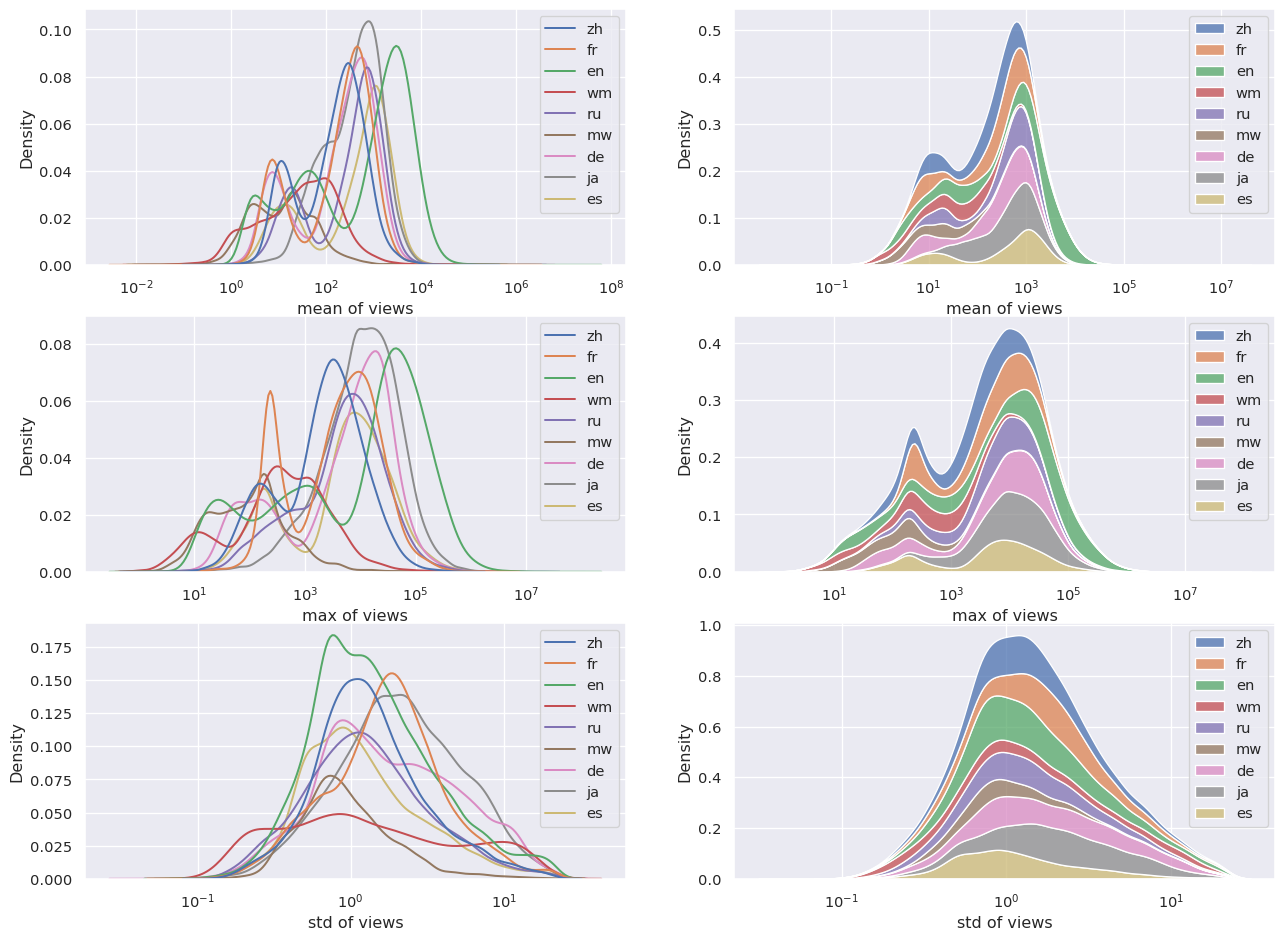

In [106]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
for i, stats_name in enumerate(ts_stats_lang_all):
    for j, mult_type in enumerate(('layer', 'stack')):
        ax = sns.kdeplot(data=ts_stats_lang_all[stats_name], log_scale=True, multiple=mult_type, ax=axes[i][j])
        _ = ax.set(xlabel=f"{stats_name} of views")

- English pages have the highest mean of views as expected.
- Spanish and Japanese view distributions are more widely spreaded.
- Chinese pages are less viewed than other languages with lower variability.

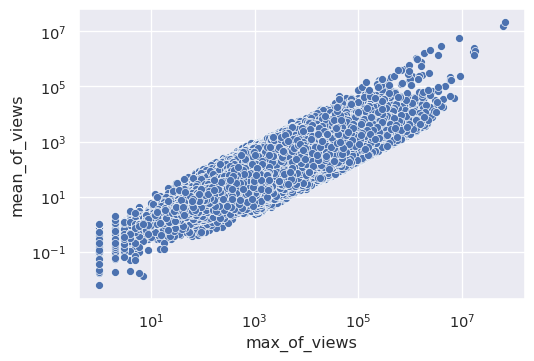

In [161]:
ax = plt.subplot()
_ = ax.set(xscale='log', yscale='log', xlabel='max_of_views', ylabel='mean_of_views')
ax = sns.scatterplot(x=ts_stats['max'].replace(0, np.nan), y=ts_stats['mean'].replace(0, np.nan), ax=ax)

- Mean of views and max of views are siginificantly correlated.

In [159]:
meta.loc[ts_stats['max'].sort_values(ascending=False)[:30].index]

,name,access,agent,lang,site
38573,Main_Page,all-access,all-agents,en,wikipedia.org
9774,Main_Page,desktop,all-agents,en,wikipedia.org
99322,Заглавная_страница,all-access,all-agents,ru,wikipedia.org
103123,Заглавная_страница,desktop,all-agents,ru,wikipedia.org
39180,Special:Search,all-access,all-agents,en,wikipedia.org
10403,Special:Search,desktop,all-agents,en,wikipedia.org
33644,Main_Page,all-access,spider,en,wikipedia.org
74114,Main_Page,mobile-web,all-agents,en,wikipedia.org
39945,David_Bowie,all-access,all-agents,en,wikipedia.org
41072,Donald_Trump,all-access,all-agents,en,wikipedia.org


In [158]:
top_index = ts_stats[(ts_stats['max']-ts_stats['mean'] > 1e5) & (ts_stats['mean'] > 1e5)].index
pd.concat([meta.loc[top_index], ts_stats.loc[top_index]], axis=1).sort_values('max', ascending=False)[:30]

,name,access,agent,lang,site,mean,std,max,min
38573,Main_Page,all-access,all-agents,en,wikipedia.org,2.195061e+07,9.103455e+06,67264258.0,13658940.0
9774,Main_Page,desktop,all-agents,en,wikipedia.org,1.598356e+07,9.557580e+06,62288712.0,8091010.0
99322,Заглавная_страница,all-access,all-agents,ru,wikipedia.org,1.979114e+06,2.866695e+06,17846030.0,865616.0
103123,Заглавная_страница,desktop,all-agents,ru,wikipedia.org,1.355855e+06,2.889305e+06,17332270.0,343105.0
39180,Special:Search,all-access,all-agents,en,wikipedia.org,2.374866e+06,1.029369e+06,16991932.0,1421005.0
10403,Special:Search,desktop,all-agents,en,wikipedia.org,1.842565e+06,9.576987e+05,16592075.0,1030746.0
33644,Main_Page,all-access,spider,en,wikipedia.org,2.361394e+05,8.352532e+05,9162565.0,9538.0
74114,Main_Page,mobile-web,all-agents,en,wikipedia.org,5.717804e+06,1.179137e+06,8752306.0,3645577.0
41072,Donald_Trump,all-access,all-agents,en,wikipedia.org,1.649075e+05,3.985485e+05,6137438.0,26675.0
34257,Special:Search,all-access,spider,en,wikipedia.org,2.276688e+05,6.306632e+05,6008070.0,512.0


# 4 Correlation of views ~ day <a class="anchor" id="correlation-views"></a>

## 4.1 Distribution of $\rho$ <a class="anchor" id="distrib-rho"></a>

In [20]:
day_index = pd.Series(range(len(list(ts))))
rho = ts.apply(lambda row: row.corr(day_index), axis=1)
rho

/home/ning/apps/mambaforge/envs/ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ning/apps/mambaforge/envs/ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


0         0.130359
1         0.098477
2         0.082098
3         0.063354
4         0.047957
            ...   
145058   -0.569102
145059         NaN
145060         NaN
145061         NaN
145062         NaN
Length: 145063, dtype: float64

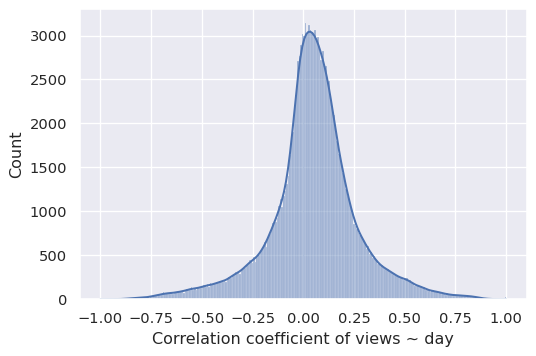

In [21]:
ax = plt.subplot(xlabel="Correlation coefficient of views ~ day")
p = sns.histplot(rho, kde=True, ax=ax)

## 4.2 Top correlated time series <a class="anchor" id="top-correlated-time-series"></a>

In [22]:
rho_desc_index = rho.sort_values(ascending=False).index
ts_rho_desc = ts.loc[rho_desc_index]
rho_desc_index_filtered = ts_rho_desc[ts_rho_desc.isnull().sum(axis=1)<100].index

rho_asc_index = rho.sort_values(ascending=True).index
ts_rho_asc = ts.loc[rho_asc_index]
rho_asc_index_filtered = ts_rho_asc[ts_rho_asc.isnull().sum(axis=1)<100].index

print("Top 20 positively correlated:")
top_pos_rho_meta = meta.loc[rho_desc_index_filtered][:20]
top_pos_rho_meta
print("Top 20 negatively correlated:")
top_neg_rho_meta = meta.loc[rho_asc_index_filtered][:20]
top_neg_rho_meta

Top 20 positively correlated:


,name,access,agent,lang,site
55586,Spécial:Recherche,mobile-web,all-agents,fr,wikipedia.org
91727,Twenty_One_Pilots,all-access,all-agents,es,wikipedia.org
78942,Main_Page,mobile-web,all-agents,wm,wikimedia.org
108340,翡翠台電視劇集列表_(2010年代),mobile-web,all-agents,zh,wikipedia.org
83924,Download,all-access,spider,mw,mediawiki.org
70771,Twenty_One_Pilots,desktop,all-agents,es,wikipedia.org
95366,Twenty_One_Pilots,mobile-web,all-agents,es,wikipedia.org
46156,File:Scabies_Penis_1.JPG,all-access,all-agents,wm,wikimedia.org
77793,Category:Nude_females,mobile-web,all-agents,wm,wikimedia.org
79979,File:Indiafilm.svg,mobile-web,all-agents,wm,wikimedia.org


Top 20 negatively correlated:


,name,access,agent,lang,site
95855,Wikipedia:Portada,mobile-web,all-agents,es,wikipedia.org
74114,Main_Page,mobile-web,all-agents,en,wikipedia.org
103658,2015_год_в_кино,desktop,all-agents,ru,wikipedia.org
8387,2015_in_film,desktop,all-agents,en,wikipedia.org
100212,2015_год_в_кино,all-access,all-agents,ru,wikipedia.org
9632,List_of_Bollywood_films_of_2015,desktop,all-agents,en,wikipedia.org
102480,Категория:Порноактрисы_по_странам,desktop,all-agents,ru,wikipedia.org
38457,List_of_Bollywood_films_of_2015,all-access,all-agents,en,wikipedia.org
30041,中国大陆电视剧列表_(2015年),all-access,all-agents,zh,wikipedia.org
113340,SxS,all-access,all-agents,en,wikipedia.org


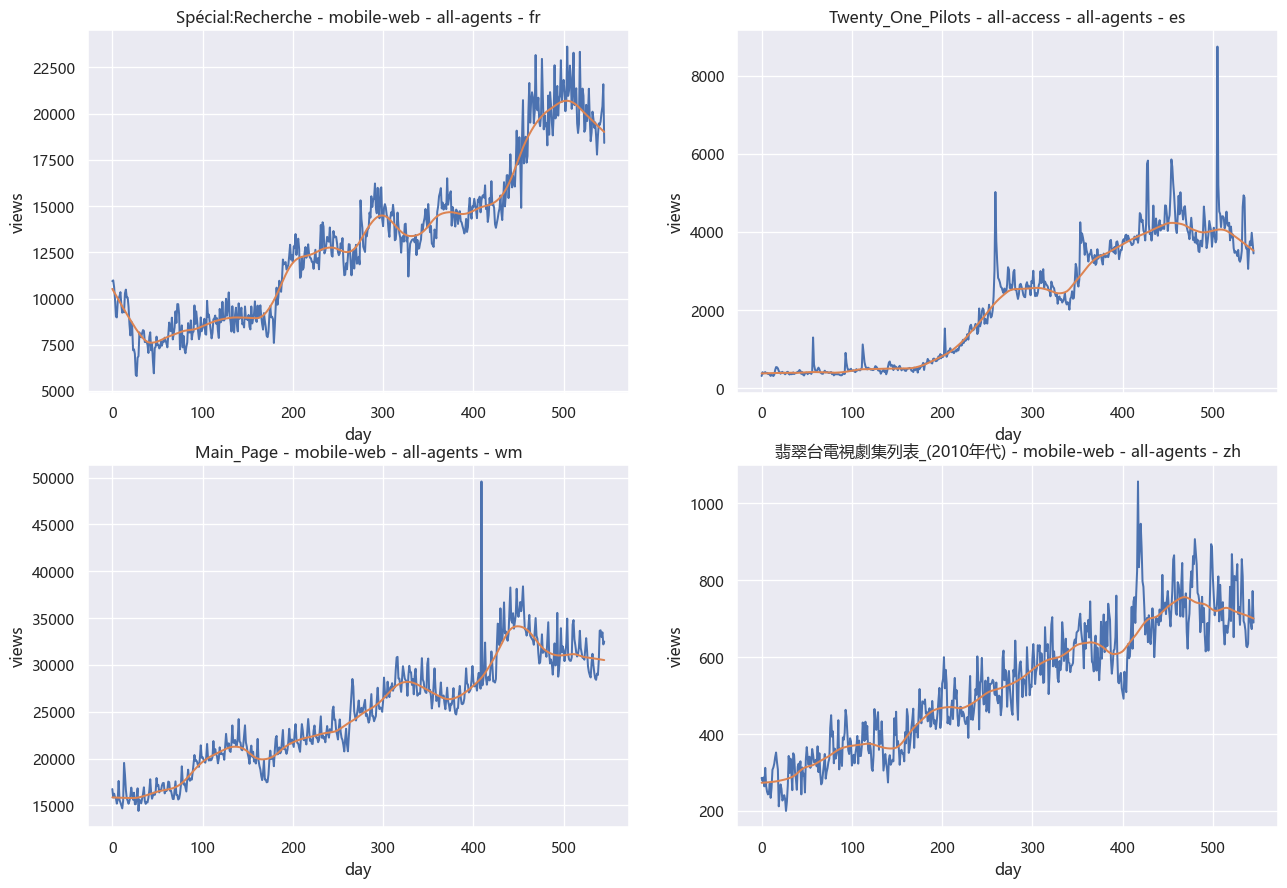

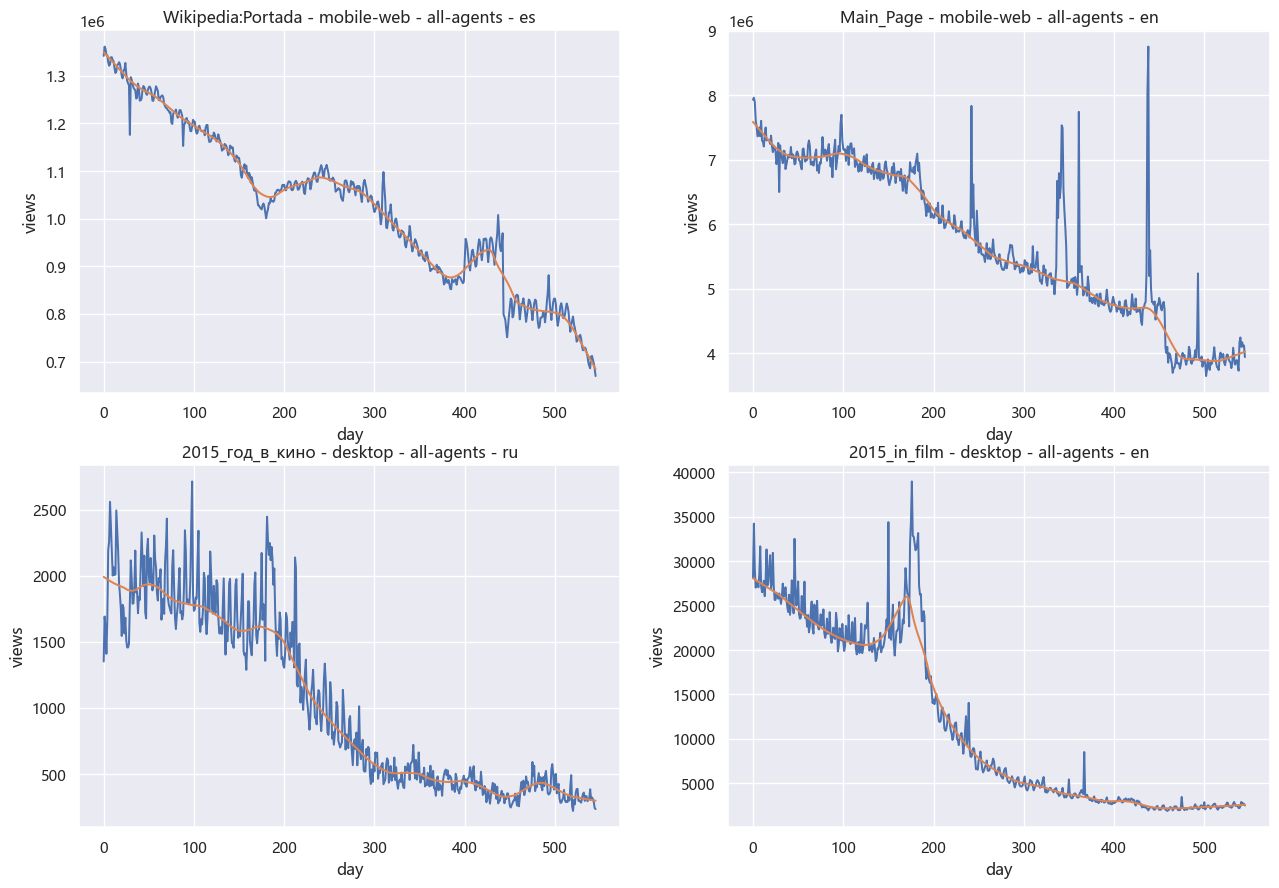

In [55]:
def plot_4_ts(top_meta, frac=0.1):
    fig, axes = plt.subplots(2, 2, figsize=(16,11))
    for i in range(2):
        for j in range(2):
            n = i * 2 + j
            row = top_meta.iloc[n]
            views = ts.loc[row.name]
            smooth = lowess(views, ts.columns, frac=frac)
            ax = axes[i][j]
            _ = ax.set(xlabel='day', ylabel='views', title=f"{row['name']} - {row.access} - {row.agent} - {row.lang}")
            _ = sns.lineplot(x=ts.columns, y=views, ax=ax)
            _ = sns.lineplot(x=ts.columns, y=smooth[:, 1], ax=ax)

plot_4_ts(top_pos_rho_meta)
plot_4_ts(top_neg_rho_meta)

# 5 Series of top mean / stdev views <a class="anchor" id="series-top-mean-stdev"></a>

## 5.1 Series of top mean views <a class="anchor" id="series-top-mean-views"></a>

In [64]:
top_mean_index = ts_stats.sort_values('mean', ascending=False).index
top_mean_meta = meta.loc[top_mean_index]
top_mean_meta[:10]

,name,access,agent,lang,site
38573,Main_Page,all-access,all-agents,en,wikipedia.org
9774,Main_Page,desktop,all-agents,en,wikipedia.org
74114,Main_Page,mobile-web,all-agents,en,wikipedia.org
139119,Wikipedia:Hauptseite,all-access,all-agents,de,wikipedia.org
39180,Special:Search,all-access,all-agents,en,wikipedia.org
116196,Wikipedia:Hauptseite,mobile-web,all-agents,de,wikipedia.org
99322,Заглавная_страница,all-access,all-agents,ru,wikipedia.org
10403,Special:Search,desktop,all-agents,en,wikipedia.org
27330,Wikipédia:Accueil_principal,all-access,all-agents,fr,wikipedia.org
92205,Wikipedia:Portada,all-access,all-agents,es,wikipedia.org


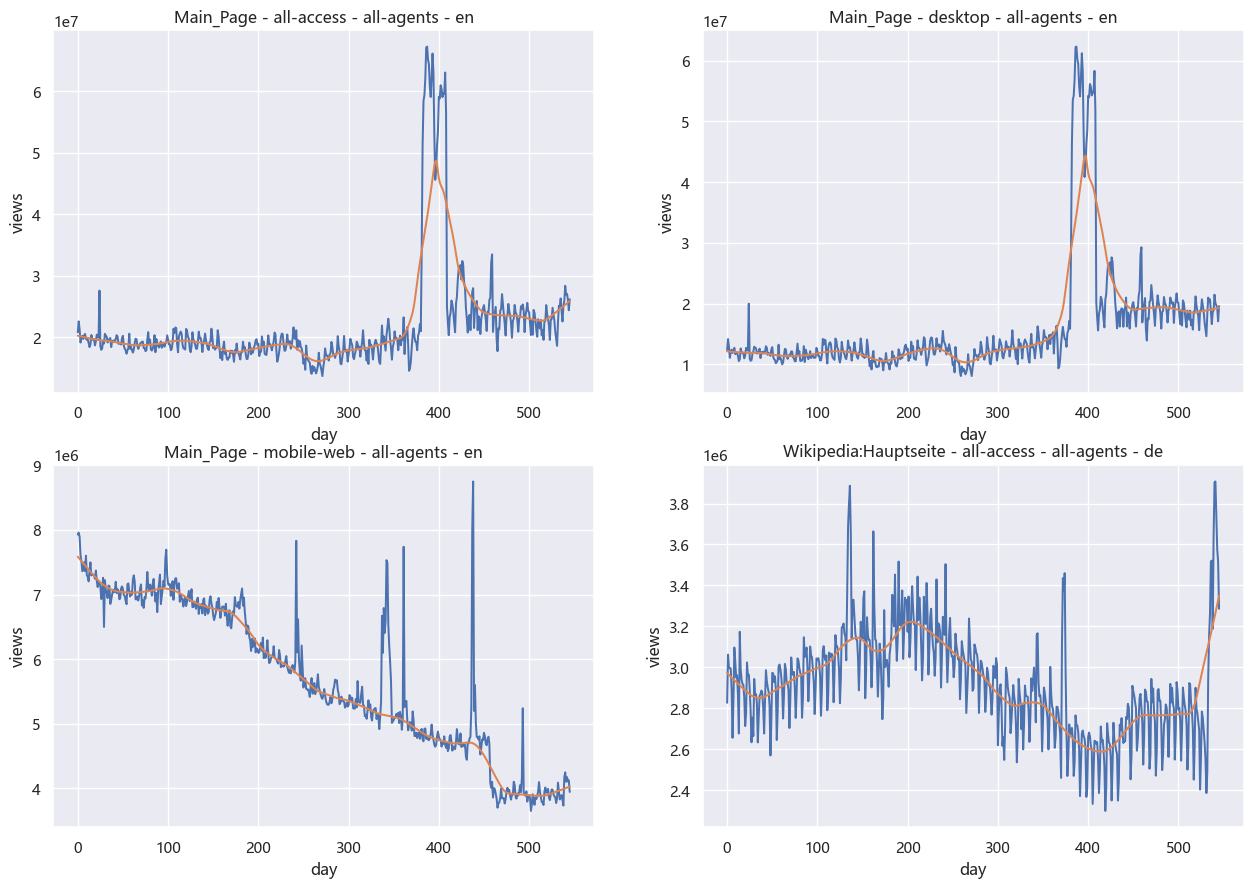

In [65]:
plot_4_ts(top_mean_meta)

## 5.2 Series of top standard deviation <a class="anchor" id="series-top-stdev"></a>

In [53]:
top_std_index = ts_stats.sort_values('std', ascending=False).index
top_std_meta = meta.loc[top_std_index]
top_std_meta[:10]

,name,access,agent,lang,site
9774,Main_Page,desktop,all-agents,en,wikipedia.org
38573,Main_Page,all-access,all-agents,en,wikipedia.org
103123,Заглавная_страница,desktop,all-agents,ru,wikipedia.org
99322,Заглавная_страница,all-access,all-agents,ru,wikipedia.org
74114,Main_Page,mobile-web,all-agents,en,wikipedia.org
39180,Special:Search,all-access,all-agents,en,wikipedia.org
10403,Special:Search,desktop,all-agents,en,wikipedia.org
33644,Main_Page,all-access,spider,en,wikipedia.org
34257,Special:Search,all-access,spider,en,wikipedia.org
40930,404.php,all-access,all-agents,en,wikipedia.org


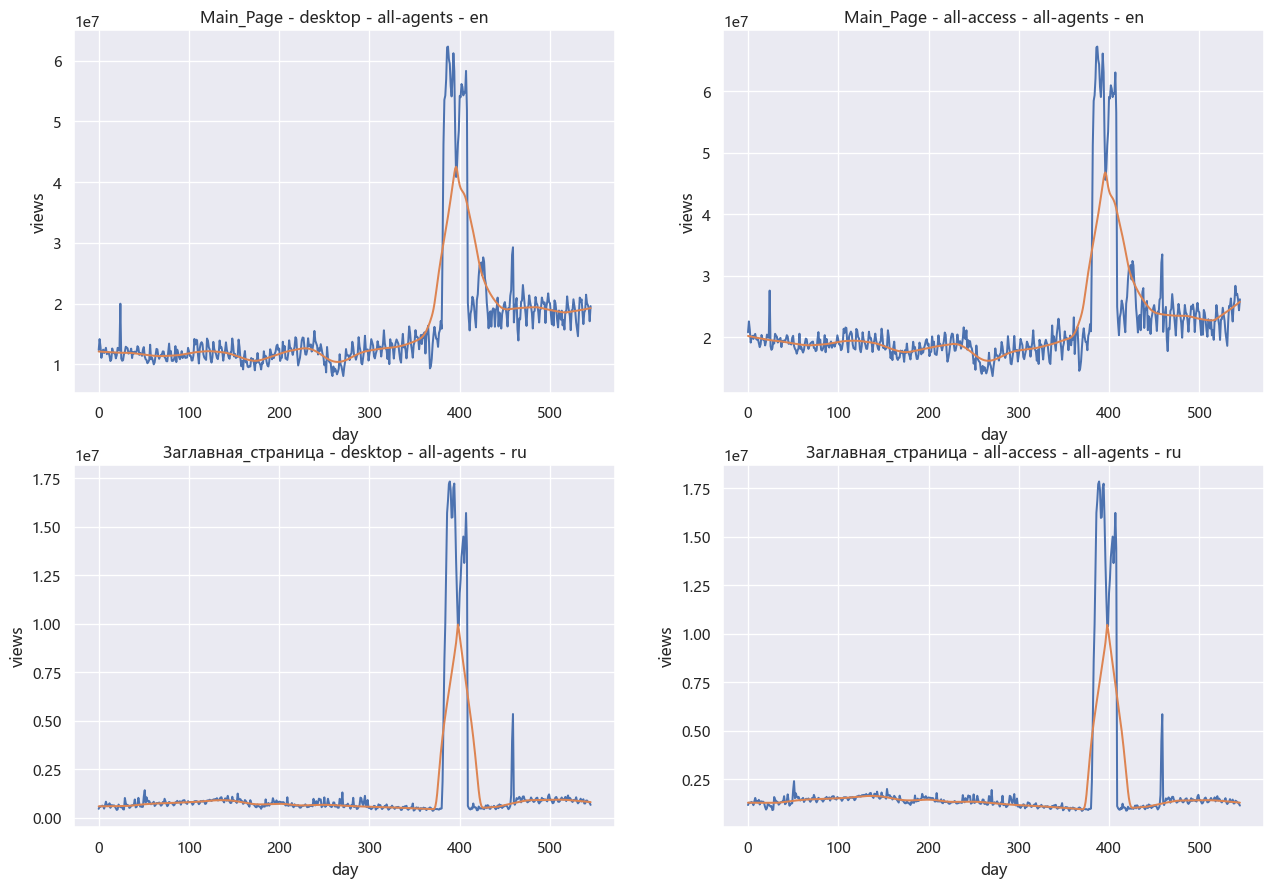

In [63]:
plot_4_ts(top_std_meta, frac=0.105)

# 6 Properties for Forecasting <a class="anchor" id="properties-forecasting"></a>

## 6.1 Seasonality <a class="anchor" id="seasonality"></a>

When zooming into time intervals without spikes, many series show a weekly seasonal pattern: higher visits over weekdays and lower visits over weekends.

In [89]:
def plot_4_ts_segment(ts_indices, start_day=100, n_days=60):
    fig, axes = plt.subplots(2, 2, figsize=(16,11))
    for i in range(2):
        for j in range(2):
            n = i * 2 + j
            row = meta.loc[ts_indices[n]]
            X = ts.columns[start_day : start_day+n_days]
            views = ts.loc[row.name][X]
            ax = axes[i][j]
            _ = ax.set(xlabel='day', ylabel='views', title=f"{row['name']} - {row.access} - {row.agent} - {row.lang}")
            _ = sns.lineplot(x=X, y=views, ax=ax)
top_mean_meta.index[:4]

38573

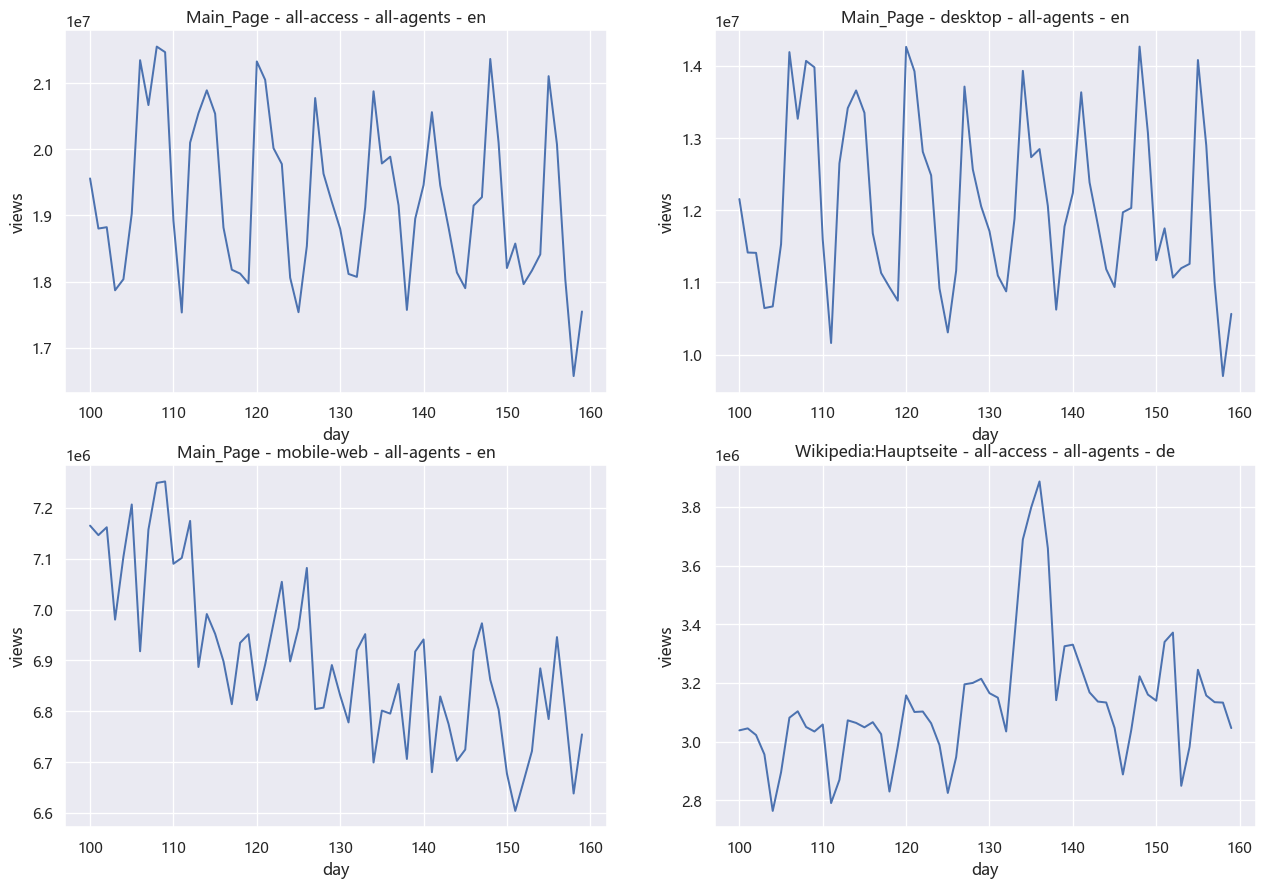

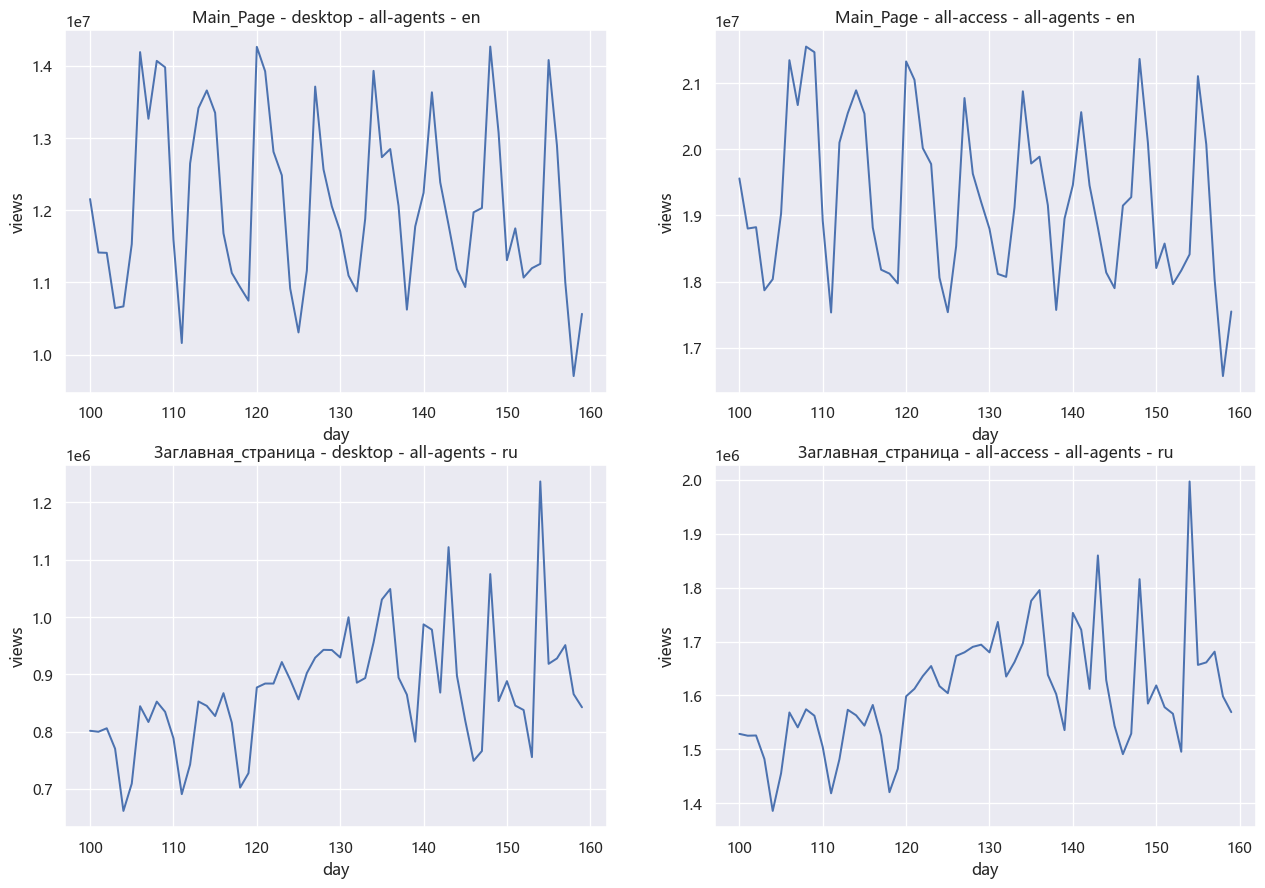

In [91]:
plot_4_ts_segment(top_mean_meta.index[:4])
plot_4_ts_segment(top_std_meta.index[:4])

## 6.2 Spectrum with FFT <a class="anchor" id="spectrum-with-fft">

In [115]:
mean_view_by_lang = meta_ts.groupby('lang').mean().T


In [122]:
from scipy.fft import fft

def plot_with_fft(ts: pd.Series):

    fig, axes = plt.subplots(2, 1, figsize=(15,12))
    #fig = plt.figure(1, figsize=(12, 5))
    #plt.ylabel('Mean of views')
    #plt.xlabel('day')
    #plt.title(ts.name)

    ax1 = axes[0]
    ax1.set(xlabel='day', ylabel='Mean of views', title=ts.name)
    ax1.plot(ts.index, ts, label=ts.name)
    
    #fig = plt.figure(2, figsize=(12, 5))
    fft_mag = np.abs(fft(ts.values))
    N = len(ts)
    fft_xvals = [day / N for day in range(N)]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    #plt.ylabel('FFT Magnitude')
    #plt.xlabel()
    #plt.title('Spectrum')
    #plt.plot(fft_xvals[1:], fft_mag[1:], label=ts.name)
    
    ax2 = axes[1]
    ax2.set(xlabel=r"Frequency [days]$^{-1}$", ylabel='FFT Magnitude', title=f"{ts.name} spectrum")
    ax2.plot(fft_xvals[1:], fft_mag[1:], label=ts.name)
    # vertical lines at harmonics of 7-day frequency
    ax2.axvline(x=1./7,color='red',alpha=0.3)
    ax2.axvline(x=2./7,color='red',alpha=0.3)
    ax2.axvline(x=3./7,color='red',alpha=0.3)


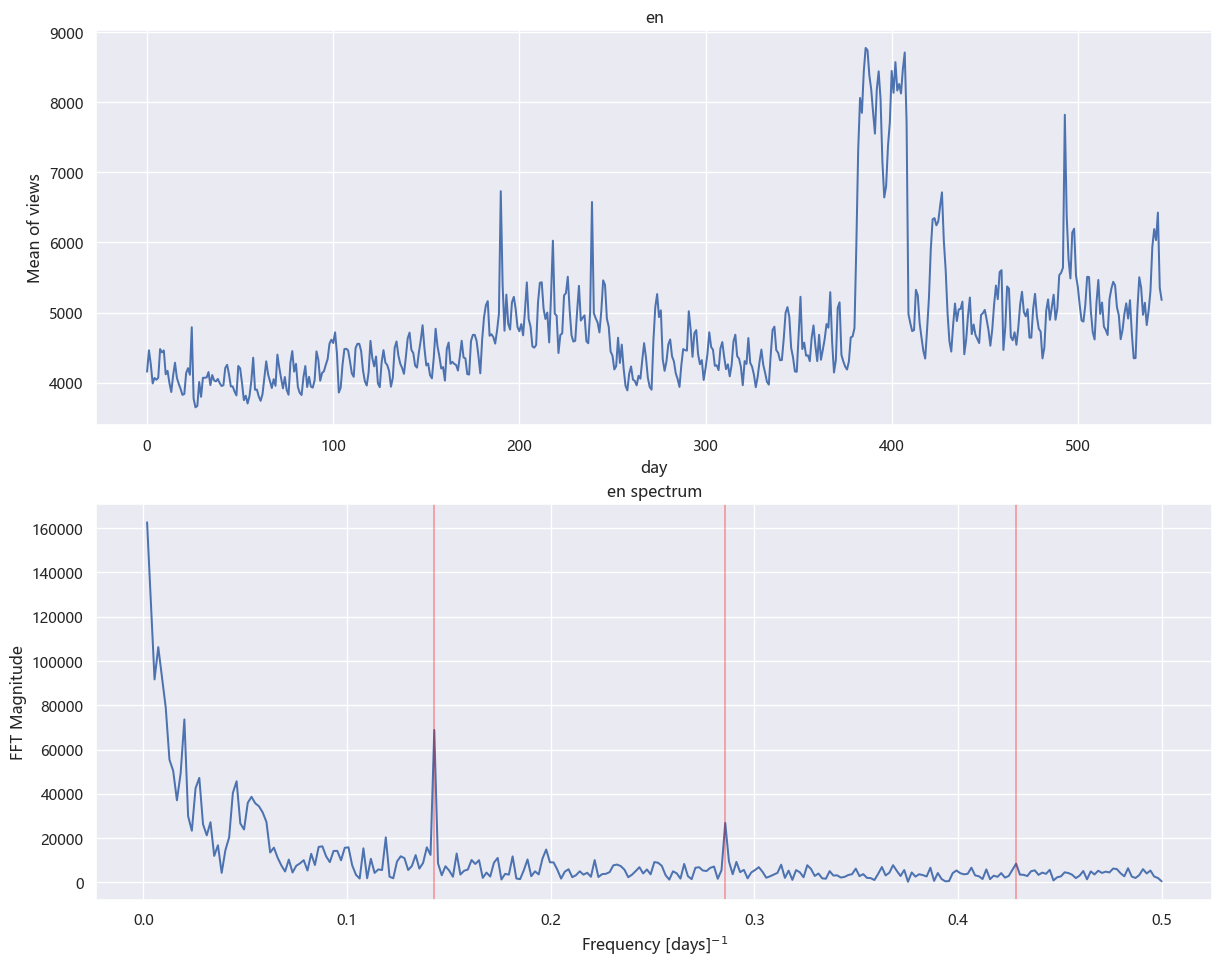

In [123]:

plot_with_fft(mean_view_by_lang['en'])

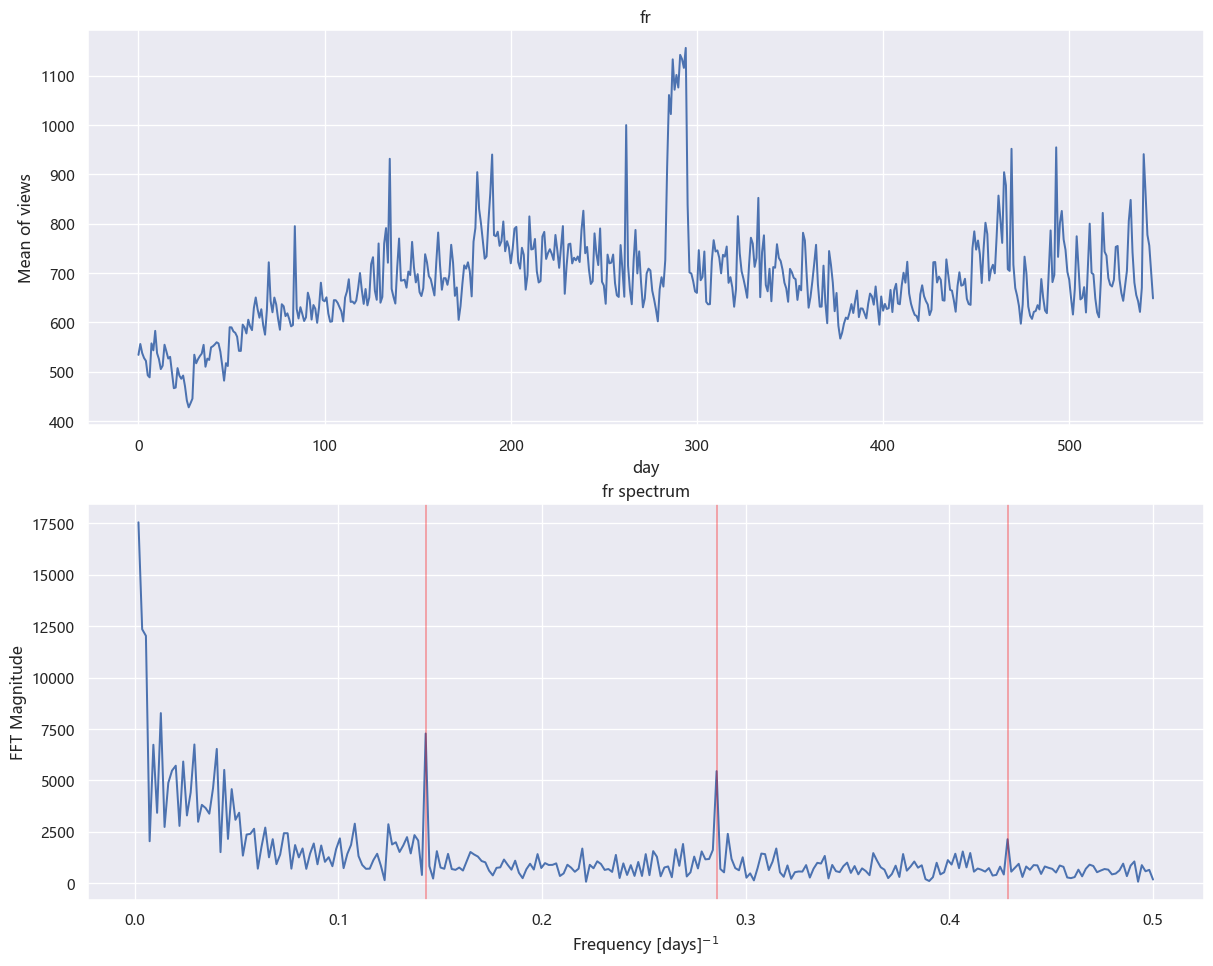

In [129]:
plot_with_fft(mean_view_by_lang['fr'])

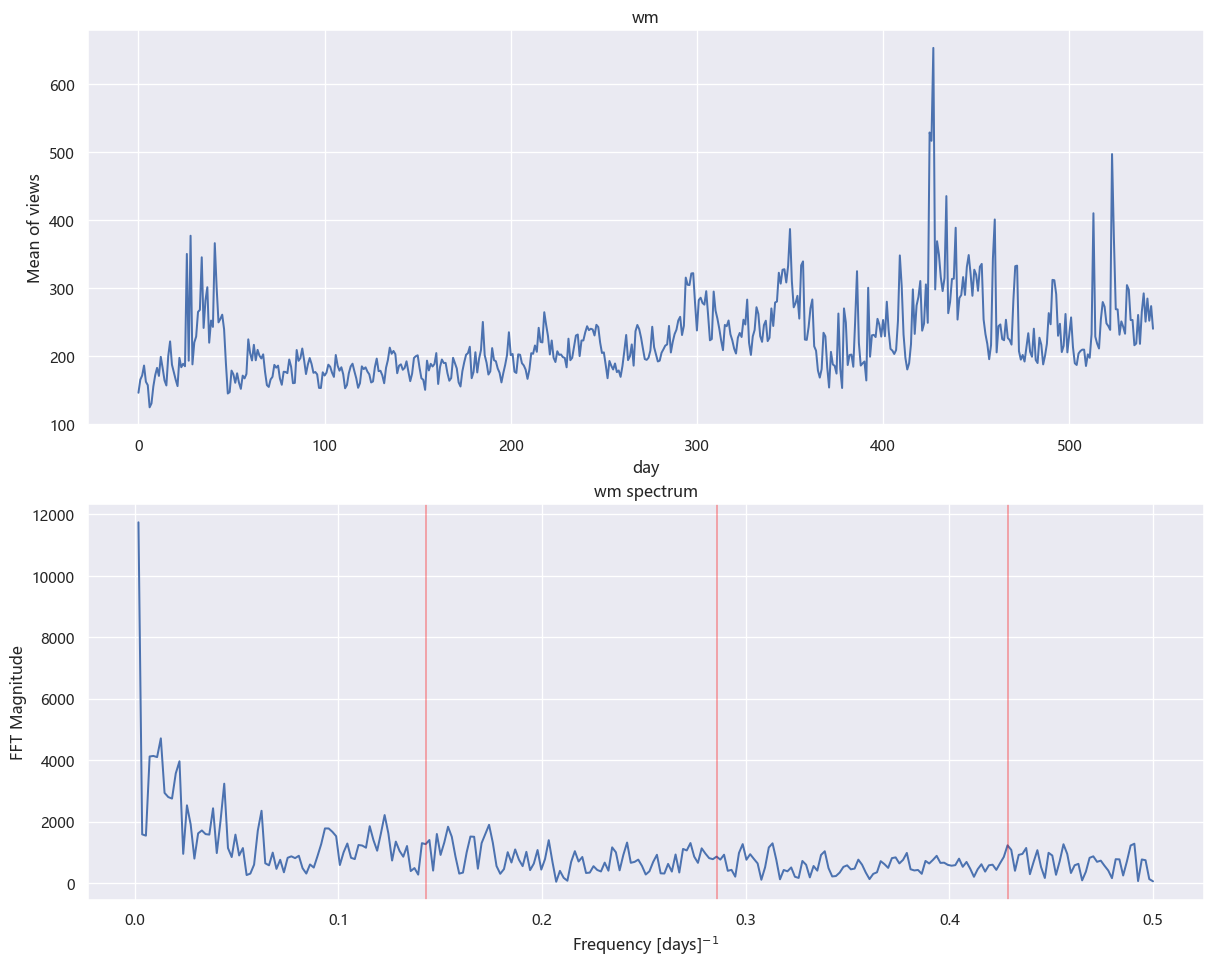

In [130]:
plot_with_fft(mean_view_by_lang['wm'])

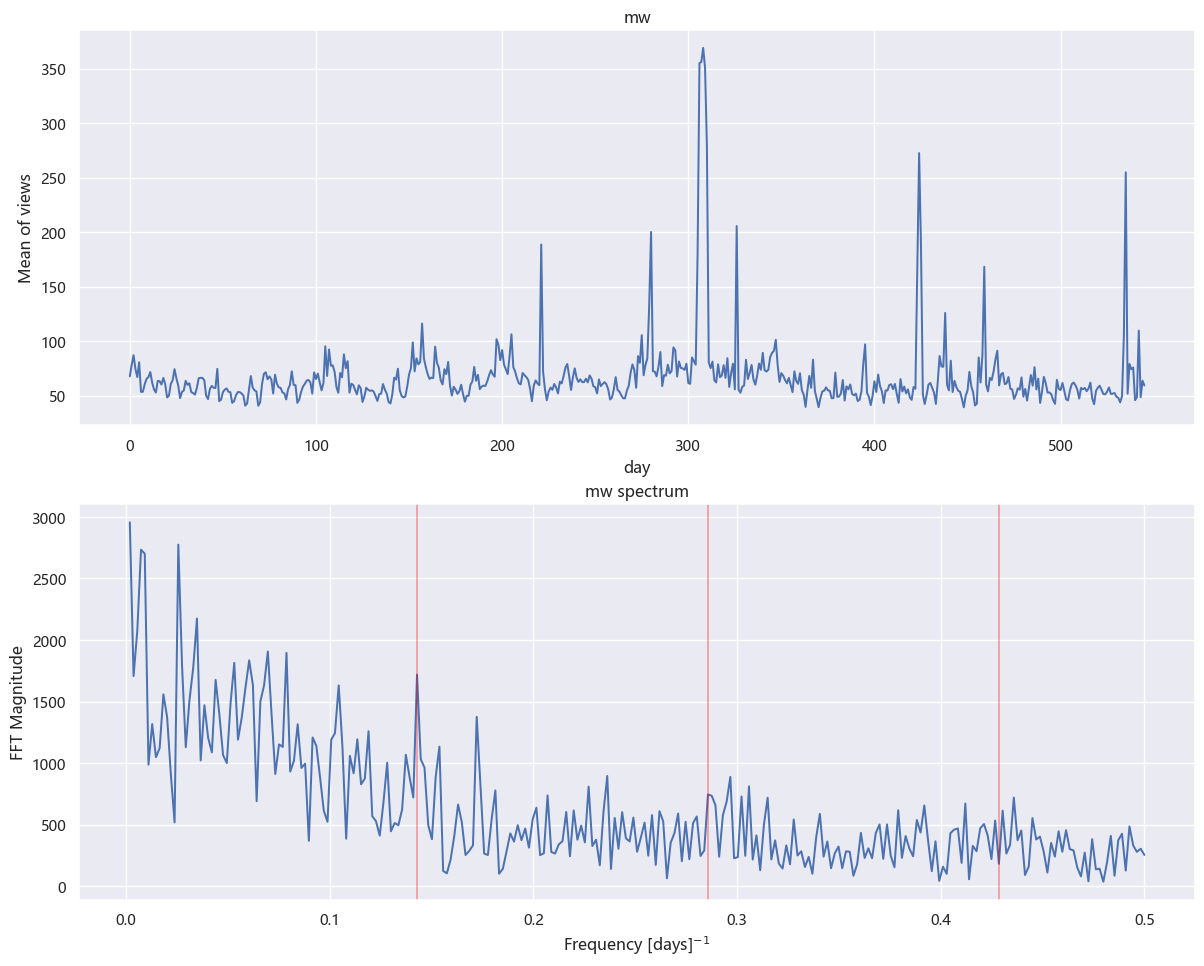

In [131]:
plot_with_fft(mean_view_by_lang['mw'])

- All languages of Wikipedia page views have spikes in frequency domain, with base frequency at 1/7 up to the third harmonic. This matches the observation of 7-day periodicity.
- Wikimedia.org and Mediawiki.org do not have such kind of periodicity obviously. They have spikes at irregular intervals, which would be difficult to forecast.

## 6.3 Autocorrelation and partial autocorrelation <a class="anchor" id="autocorrelation-partial-autocorrelation"></a>

In [154]:
import statsmodels.api as sm

def plot_autocorr(s, lags=50, figsize=(12,5), title=''): 
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    acf_ax, pacf_ax = axes
    sm.graphics.tsa.plot_acf(s, ax=acf_ax, lags=lags, fft=True, zero=False, title=f'Autocorrelation of {title}')
    sm.graphics.tsa.plot_pacf(s, ax=pacf_ax, lags=lags, method='ywm', zero=False, title=f'Partial Autocorrelation of {title}')

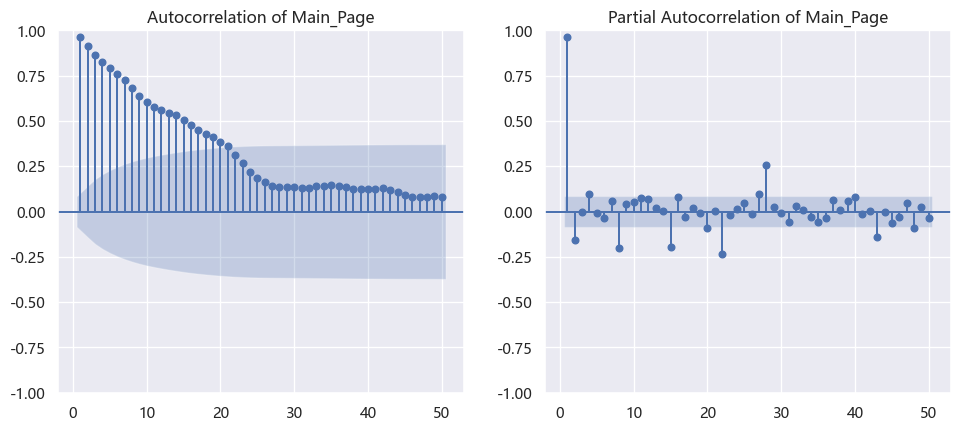

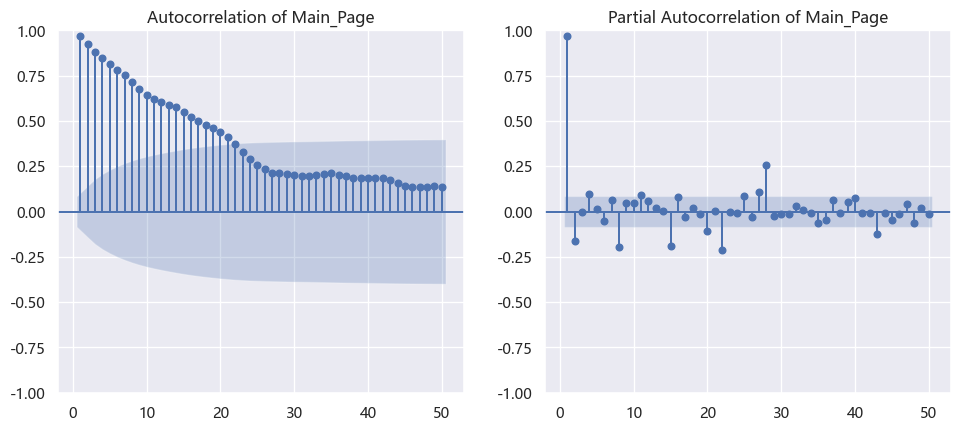

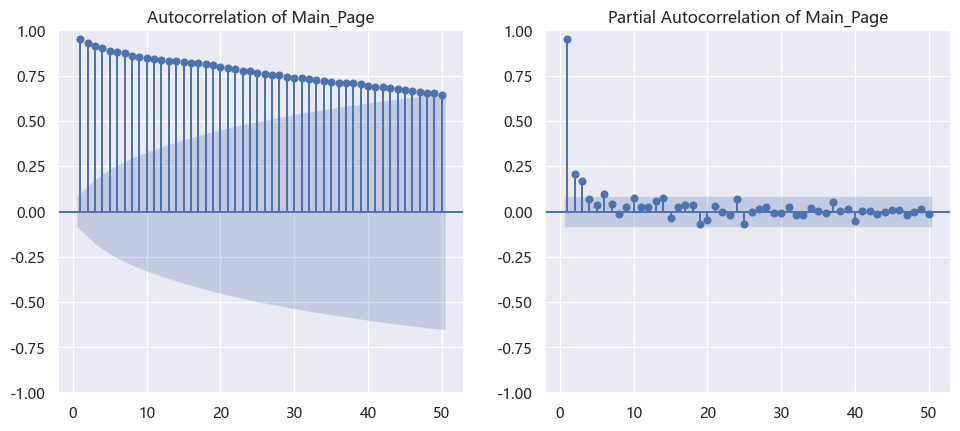

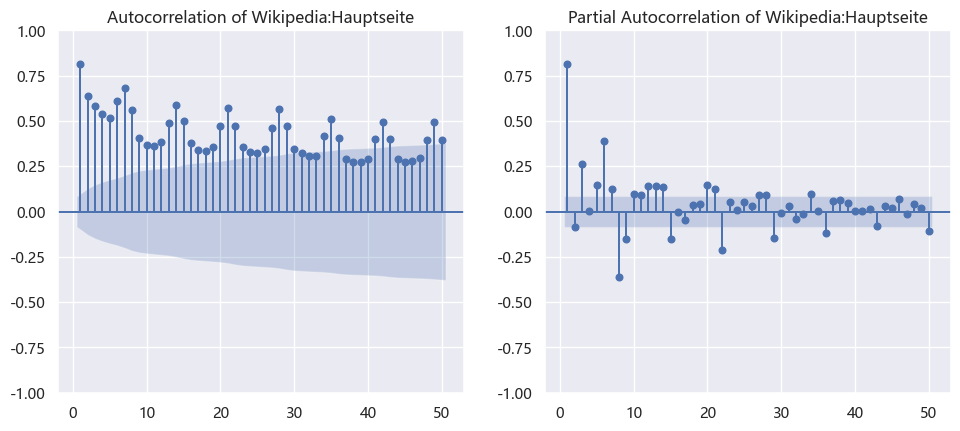

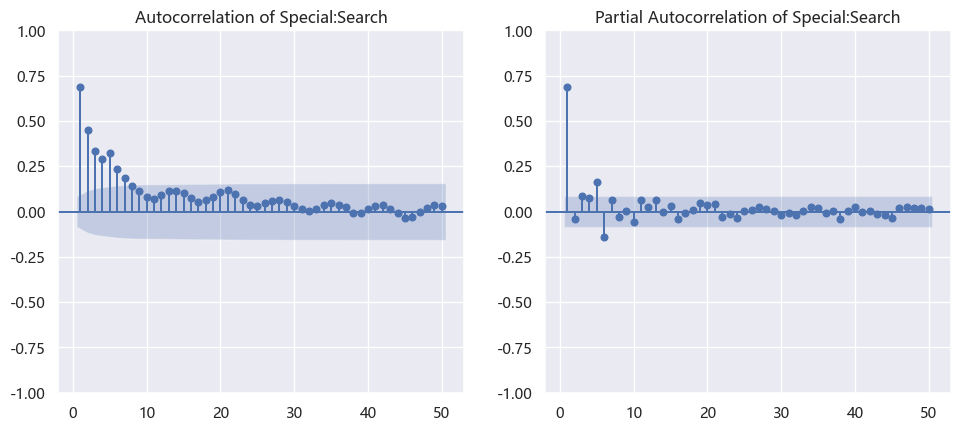

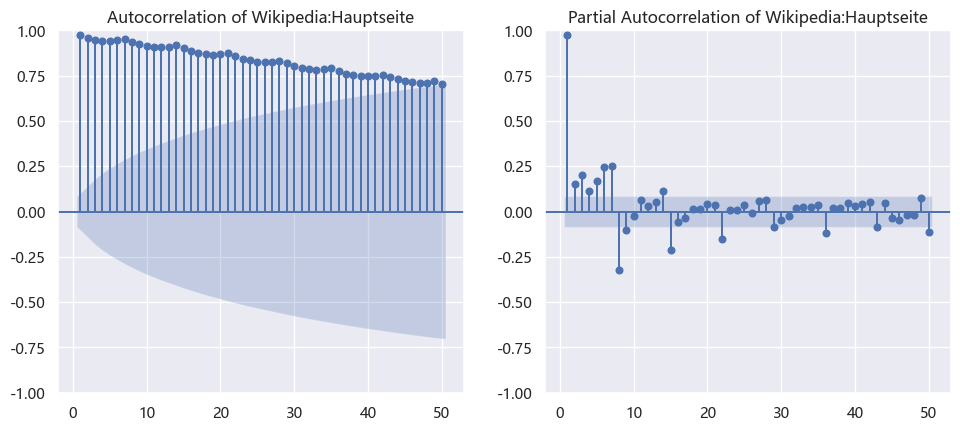

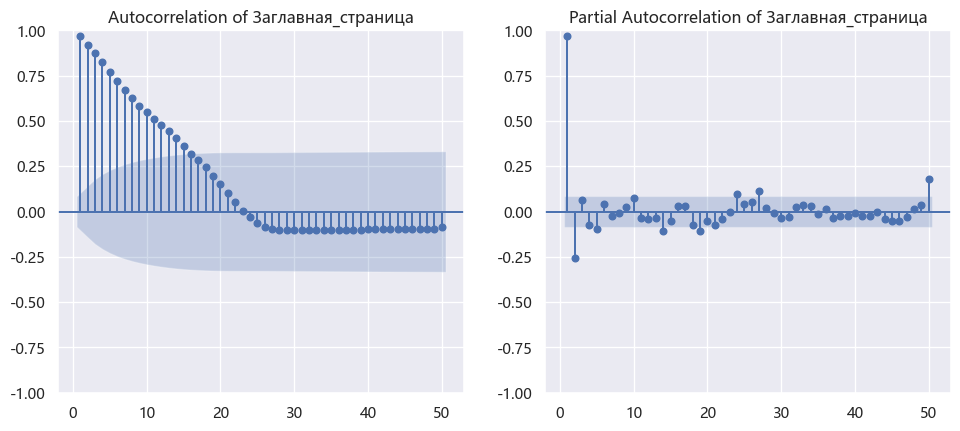

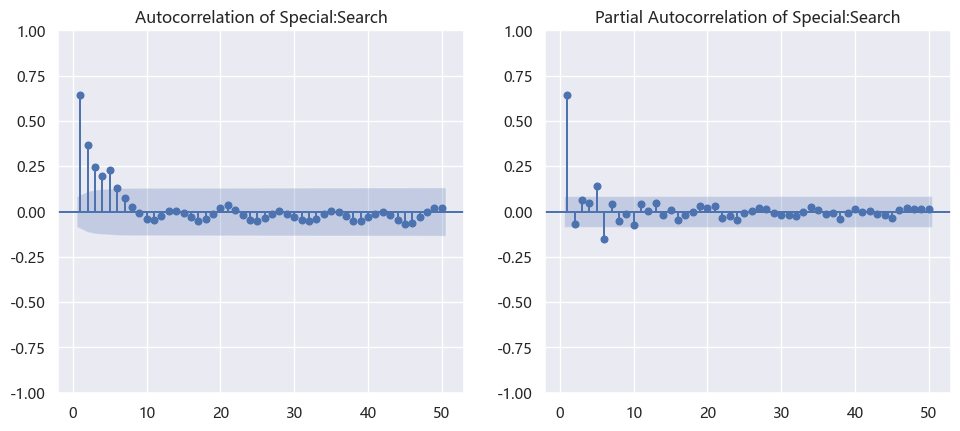

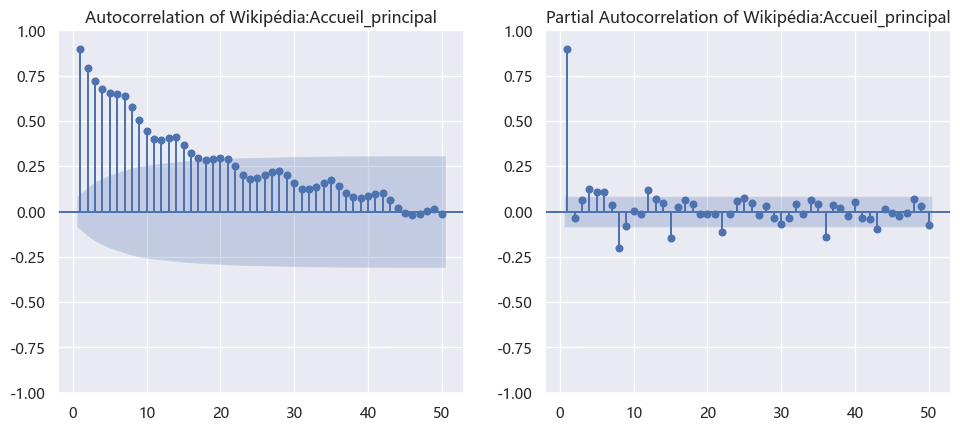

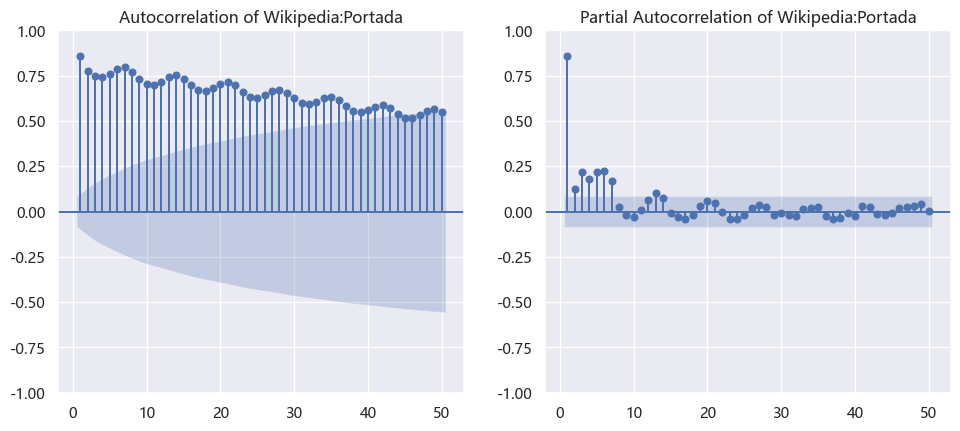

In [155]:
for idx in ts_stats.sort_values('mean', ascending=False)[:10].index:
    plot_autocorr(ts.loc[idx], title=meta.loc[idx]['name'])

- Many top viewed pages have a tail-off acf and cuts-off pacf, indicating a clear autoregressive (AR) component process.
- Some pages also have a slight tail-off pacf that signals ARIMA component processes.

## 6.4 Augmented Dickey-Fuller tests <a class="anchor" id="adf-tests"></a>

In [189]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

pvals = {}
for idx in ts_stats.sort_values('mean', ascending=False)[:1000].index:
    x = ts.loc[idx].fillna(0)
    decompose_result = seasonal_decompose(x, model='additive', period=7)  # trend + 7-day seasonal series

    pval = adfuller(decompose_result.trend.fillna(0), autolag='AIC')[1]
    meta_row = meta.loc[idx]
    title=f"{meta_row['name']} - {meta_row['access']} - {meta_row['agent']}"
    pvals[title] = pval

pval_df = pd.DataFrame(pvals, index=['p']).T
stationary_perc = (len(pval_df.query("p < 0.05")) / len(pval_df)) * 100
print(f"There are {stationary_perc}% stationary series.")
pval_df

There are 62.668045501551184% stationary series.


,p
Main_Page - all-access - all-agents,0.251996
Main_Page - desktop - all-agents,0.256085
Main_Page - mobile-web - all-agents,0.030087
Wikipedia:Hauptseite - all-access - all-agents,0.537351
Special:Search - all-access - all-agents,0.023823
...,...
List_of_WWE_personnel - all-access - all-agents,0.013766
Spectre_(2015_film) - desktop - all-agents,0.091397
Napoleon - all-access - all-agents,0.343043
Lyme_disease - all-access - all-agents,0.004383


- For the top 50 mostly viewed pages, only about half are stionary time series.
- There are more stationary series among less-viewed pages. It may not be real because of large amount of 0-filling for NaN values.
- Using methods for forecasting staionary time series, such as ARIMA modeling, may not be approprite for this dataset, at lease not good for the mostly active pages.
- In the modeling notebook, machine learning modeling methods are explored to forecast these time series.

In [1]:
# backup code
# def load_train_data(train_csv: str):
#     """
#     Load train_2 from train_2.csv or cached train_2.pkl.
#     """
#     p_train = Path(train_csv).expanduser().resolve()

#     # check cached binary
#     p_train_cached = p_train.with_suffix('').with_suffix('.pkl')
#     if p_train_cached.exists():
#         print(f"Load data from cache: {p_train_cached}")
#         return pd.read_pickle(p_train_cached)

#     # load and process CSV
#     data = pd.read_csv(p_train).set_index('Page').sort_index()
    
#     # Remove GoogleAnalyitycsRoman that incured huge traffic spikes and was banned by Wikipedia.
#     data = data[~data.index.str.startswith("User:GoogleAnalitycsRoman")]

#     # Save to cache
#     data.to_pickle(p_train_cached)

#     return data

# train = load_train_data(train_csv)

# def filter_transform_data(train: pd.DataFrame, threadshold=0.0) -> tuple:
#     """
#     - For each time series, locate the actual start/end day by excluding the leading and trailing 0-view days.
#     - Filter out time series that have too many 0-view days.
#     - Apply log(1+x) transformation on NaN-filled data, and record NaN positions.

#     """
#     stat_day
#     end_day

# train[~(train.sum(axis=1) == 0)]